In [1]:
from util import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn.decomposition import PCA
from nilearn.input_data import NiftiMapsMasker

/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
def read_data(subject_id):
    fmri_images = list()
    #mask_image = list()
    for run in range(1, 11):
        if run%2 == 0:
            task = 'rotate'
        else:
            task = 'straight'
        fmri_file = f"data/derivatives/sub-{subject_id}/func/sub-{subject_id}_task-{task}_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
        fmri_images.append(fmri_file)
    return fmri_images


In [3]:
def extract_prep_events_and_indices(events):
    #extracting prep events
    prep_events = events[events['trial_type'].str.contains('prep')].reset_index().drop('index', 1)

    #Renaming conditions column
    prep_events['target_location'] = '207'
    prep_events.loc[prep_events['trial_type'].str.contains('45'), 'target_location'] = '45'
    prep_events.loc[prep_events['trial_type'].str.contains('99'), 'target_location'] = '99'
    prep_events.loc[prep_events['trial_type'].str.contains('153'), 'target_location'] = '153'
    prep_events = prep_events.drop('trial_type', 1)
    prep_events = prep_events.sort_values(by='onset')
    indices = np.floor(prep_events['onset']/1.25).astype(int).values + 3

    return prep_events, indices

In [4]:
def extract_prep_images(indices, fmri_run_image):    
    #Extracting functionl images that correspond to prep times
    prep_images = image.index_img(fmri_run_image, np.ravel(np.vstack((indices, indices+1)), order = 'F'))
    return prep_images


In [5]:
atlas = datasets.fetch_atlas_juelich("maxprob-thr25-2mm")

In [6]:
masks = {"premotor":"GM Premotor cortex BA6", 
         "motor": "GM Primary motor cortex BA4a",
         "v1": "GM Visual cortex V1 BA17",
         "sup_parietal": "GM Superior parietal lobule 7P",
         "inf_parietal": "GM Inferior parietal lobule PF",
         "somatosensory": "GM Primary somatosensory cortex BA1"
        }


In [3]:
atlas = datasets.fetch_atlas_msdl()
masks = {"motor": "Motor", 
         "parietal": "L Par",
         "vis": "Vis",
         "cerebellum": "Cereb"       
        }

## Voxel Correlations within and across dimensions 

In [7]:
def save_within_correlations(subject_id, atlas, masks, save = True):
    correlations = pd.DataFrame({'runs': np.repeat(np.arange(1, 11), len(masks)),
                               'block_type': np.tile(np.repeat(['Straight', 'Rotate'], len(masks)), 5),
                               'ROIs': np.tile(list(masks.keys()), 10),
                                '45_45': np.zeros(len(masks)*10),
                                '45_99': np.zeros(len(masks)*10),
                                '45_153': np.zeros(len(masks)*10),
                                '45_207': np.zeros(len(masks)*10),

                                '99_45': np.zeros(len(masks)*10),
                                '99_99': np.zeros(len(masks)*10),
                                '99_153': np.zeros(len(masks)*10),
                                '99_207': np.zeros(len(masks)*10),

                                '153_45': np.zeros(len(masks)*10),
                                '153_99': np.zeros(len(masks)*10),
                                '153_153': np.zeros(len(masks)*10),
                                '153_207': np.zeros(len(masks)*10),

                                '207_45': np.zeros(len(masks)*10),
                                '207_99': np.zeros(len(masks)*10),
                                '207_153': np.zeros(len(masks)*10),
                                '207_207': np.zeros(len(masks)*10),
                              })

    for run in range(1, 11):
        run_no = str(run).zfill(2)
        beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
        run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

        z_maps = {}

        for i in run_beta_maps:
            z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

        #Sorted by first number
        all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))
        mean_image = image.mean_img(all_images)
        mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)
        #mean_centered = all_images
        for i, key in enumerate(np.sort(list(z_maps.keys()))):

            z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))

            #For single beta map for odd vs even
            #z_maps[key] = image.index_img(mean_centered, slice(i*2,i*2+2))

        for mask in masks.keys():
            even_dir_dict = {}
            odd_dir_dict = {}
            dir_dict = {}

            for direction in z_maps.keys():
                #IF Jueliech, uncomment line below
                mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
                resampled_mask = image.resample_to_img(mask_image, z_maps[direction], interpolation='nearest')
                fmri_masked = masking.apply_mask(z_maps[direction], mask_img=resampled_mask)

                #IF MSDL, uncomment three lines below
                #masker = NiftiMapsMasker(maps_img=atlas.maps)
                #fmri_masked = masker.fit_transform(z_maps[direction])
                #fmri_masked = fmri_masked[:, np.where(np.array(atlas.labels) == masks[mask])[0][0]]



                even = fmri_masked[0::2]
                odd = fmri_masked[1::2]

                #even_centered = even - np.mean(even, axis=0)
                #odd_centered = odd - np.mean(odd, axis = 0)


                even_dir_dict[direction] = np.mean(even, axis = 0)
                odd_dir_dict[direction] = np.mean(odd, axis = 0)
                dir_dict[direction] = np.mean(fmri_masked, axis = 0)

            for c in correlations.columns[3:]:
                even, odd = c.split('_')
                #print(stat.pearsonr(dir_dict_straight[straight], dir_dict_rotate[rotate])[0])
                correlations.loc[((correlations['runs'] == run) & (correlations['ROIs'] == mask) ), c] = stat.pearsonr(even_dir_dict[even], odd_dir_dict[odd])[0] 
        #print('Run Done: ', run)
        
    if save:
        #Saving Correlations
        path = f'analyses_results/sub-{subject_id}/mvpa/correlations/'
        if not os.path.exists(path):
            os.makedirs(path)
        correlations.to_csv(path+'within_correlations.csv')
    
    return correlations

In [8]:
def save_between_correlations(subject_id, atlas, masks, save = True):
    bw_correlations = pd.DataFrame({'run_pairs': np.tile(np.arange(1, 6), len(masks)),
                           #'block_type': np.tile(np.repeat(['Straight', 'Rotate'], 8), 5),
                                'ROIs': np.repeat(list(masks.keys()), 5),
                                '45_45': np.zeros(len(masks)*5),
                                '45_99': np.zeros(len(masks)*5),
                                '45_153': np.zeros(len(masks)*5),
                                '45_207': np.zeros(len(masks)*5),
                                                               
                                '99_45': np.zeros(len(masks)*5),
                                '99_99': np.zeros(len(masks)*5),
                                '99_153': np.zeros(len(masks)*5),
                                '99_207': np.zeros(len(masks)*5),

                                '153_45': np.zeros(len(masks)*5),
                                '153_99': np.zeros(len(masks)*5),
                                '153_153': np.zeros(len(masks)*5),
                                '153_207': np.zeros(len(masks)*5),

                                '207_45': np.zeros(len(masks)*5),
                                '207_99': np.zeros(len(masks)*5),
                                '207_153': np.zeros(len(masks)*5),
                                '207_207': np.zeros(len(masks)*5),
                               
                               })
    
    for mask in masks.keys():
        mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])

        for run in range(1, 11):
            run_no = str(run).zfill(2)
            beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
            run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

            z_maps = {}

            for i in run_beta_maps:
                z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))


            all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'],z_maps['99']))
            mean_image = image.mean_img(all_images)
            mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)
            #print (image.index_img(mean_centered, 25))
            #mean_centered = all_images
            for i, key in enumerate(np.sort(list(z_maps.keys()))):
                z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))
                #z_maps[key] = image.index_img(mean_centered, slice(i*2,i*2+2))
                #z_maps[key] = image.index_img(mean_centered, slice(i*1,i*1+1))


            if run%2 != 0:
                dir_dict_straight = {}
                for direction in z_maps.keys():

                    resampled_mask = image.resample_to_img(mask_image, z_maps[direction], interpolation='nearest')

                    fmri_masked = masking.apply_mask(z_maps[direction], mask_img=resampled_mask)
                    dir_dict_straight[direction] = np.mean(fmri_masked, axis = 0)

            else:

                dir_dict_rotate = {}
                for direction in z_maps.keys():
                    resampled_mask = image.resample_to_img(mask_image, z_maps[direction], interpolation='nearest')
                    #nifti_masker = NiftiMasker(mask_img=resampled_mask, standardize=True)

                    fmri_masked = masking.apply_mask(z_maps[direction], mask_img=resampled_mask)
                    dir_dict_rotate[direction] = np.mean(fmri_masked, axis = 0)

                for c in bw_correlations.columns[2:]:
                    straight, rotate = c.split('_')
                    #print(stat.pearsonr(dir_dict_straight[straight], dir_dict_rotate[rotate])[0])
                    bw_correlations.loc[((bw_correlations['run_pairs'] == int(run/2)) & (bw_correlations['ROIs'] == mask) ), c] = stat.pearsonr(dir_dict_straight[straight], dir_dict_rotate[rotate])[0]



        #print('Mask Done: ', mask)

    if save:
        #Saving Correlations
        path = f'analyses_results/sub-{subject_id}/mvpa/correlations/'
        if not os.path.exists(path):
            os.makedirs(path)
        bw_correlations.to_csv(path+'between_correlations.csv')

    return bw_correlations

In [ ]:
for subject_id in ['12', '13']:
    _ = save_within_correlations(subject_id, atlas, masks)
    _ = save_between_correlations(subject_id, atlas, masks)
    print("Subject Done: ", subject_id)

Subject Done:  12


In [9]:
correlations_melt = correlations.melt(id_vars=['runs', 'block_type', 'ROIs'], var_name = 'correlations', value_name='corr')

NameError: name 'correlations' is not defined

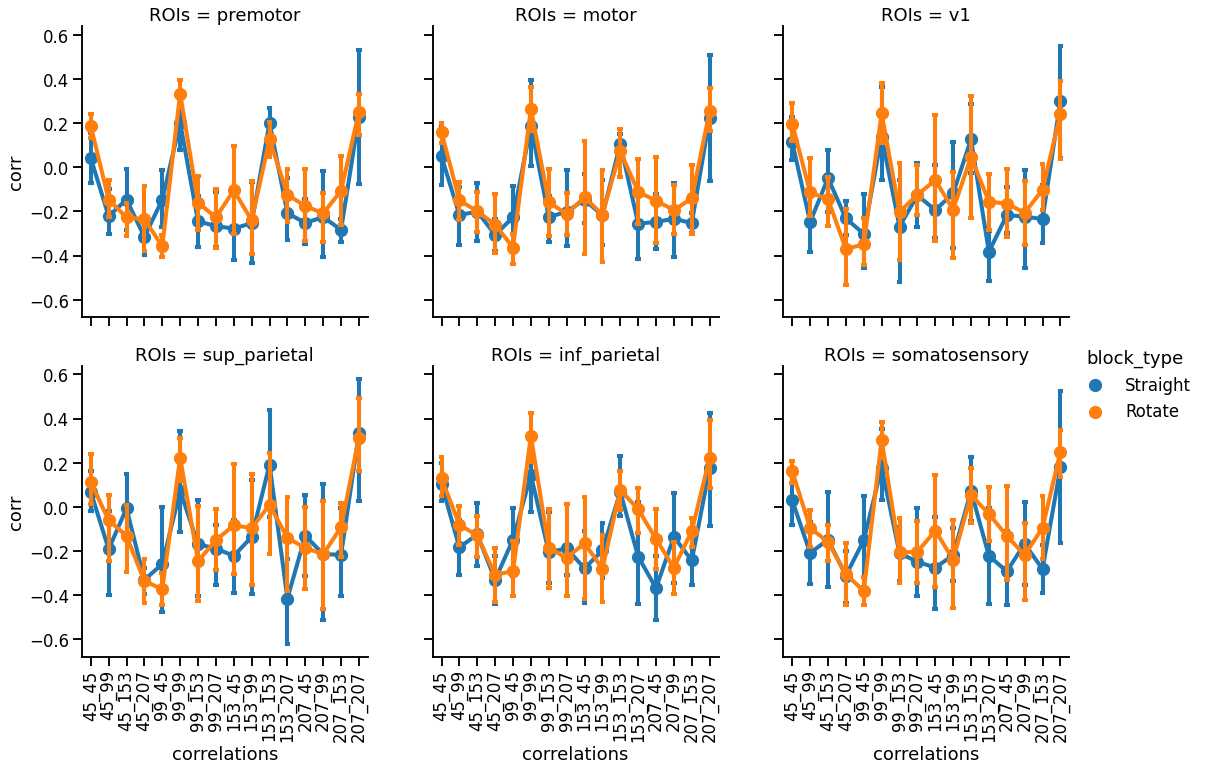

In [13]:
sns.set_context('talk')
g = sns.catplot(x = 'correlations', y = 'corr', hue = 'block_type', col = 'ROIs', col_wrap = 3,
                kind = 'point', data = correlations_melt.loc[correlations_melt['runs'] < 11], capsize = 0.1)

g.set_axis_labels().set_xticklabels(rotation = 90)
#plt.savefig('plots_for_bb/')

In [53]:
bw_correlations_melt = bw_correlations.melt(id_vars=['run_pairs', 'ROIs'], var_name = 'correlations', value_name='corr')

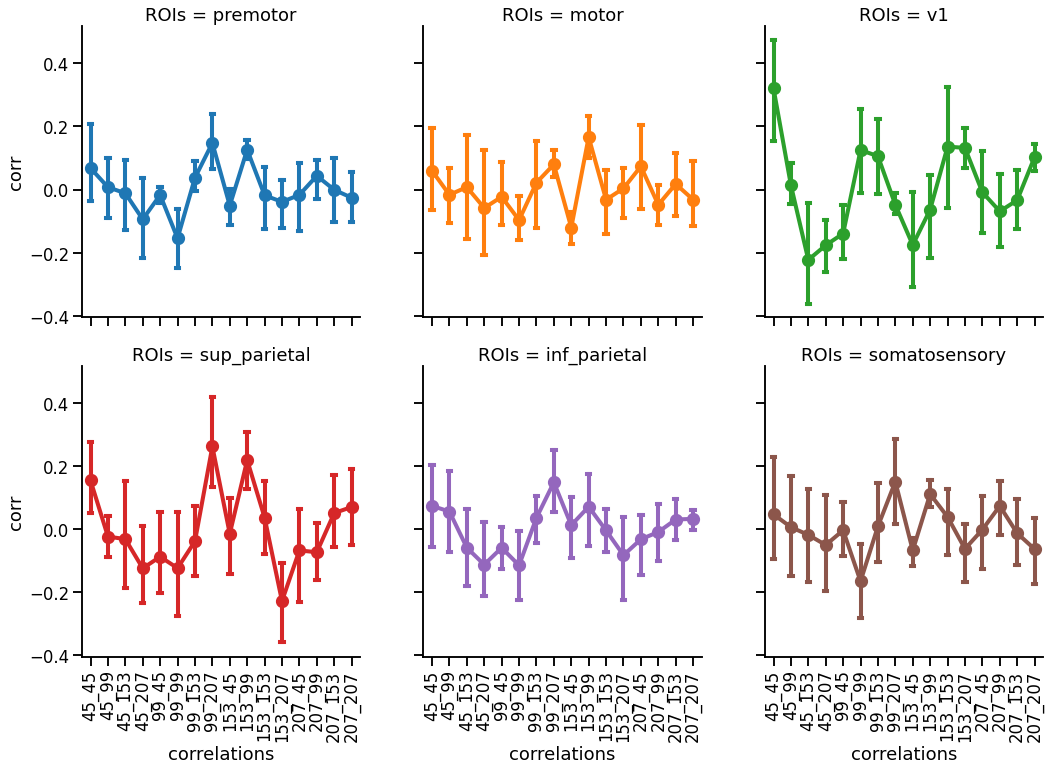

In [18]:
sns.set_context('talk')

ax = sns.catplot(x = 'correlations', y = 'corr', hue = 'ROIs', col = 'ROIs', col_wrap=3,
                 kind = 'point', capsize = 0.2,
                 data = bw_correlations_melt.loc[((bw_correlations_melt['run_pairs'] <= 5) )])

ax.set_axis_labels().set_xticklabels(rotation = 90)
#plt.savefig('plots_for_bb/bw_corr_all_pairs_non_mc.png', dpi = 600)

In [54]:
aim = []
for i in bw_correlations_melt.correlations.str.split('_').values:
    aim.append((int(i[0]) - (int(i[1]) - 90)))
bw_correlations_melt['aim_diff'] = aim

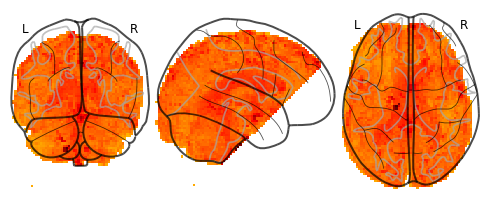

In [64]:
plot_glass_brain(image.mean_img('data/sub-12/func/sub-12_task-rotate_run-02_bold.nii.gz'), annotate=True)

In [56]:
bw_correlations_melt = bw_correlations_melt[~( (bw_correlations_melt['aim_diff'] == -72 ) | (bw_correlations_melt['aim_diff'] == 252 ))]

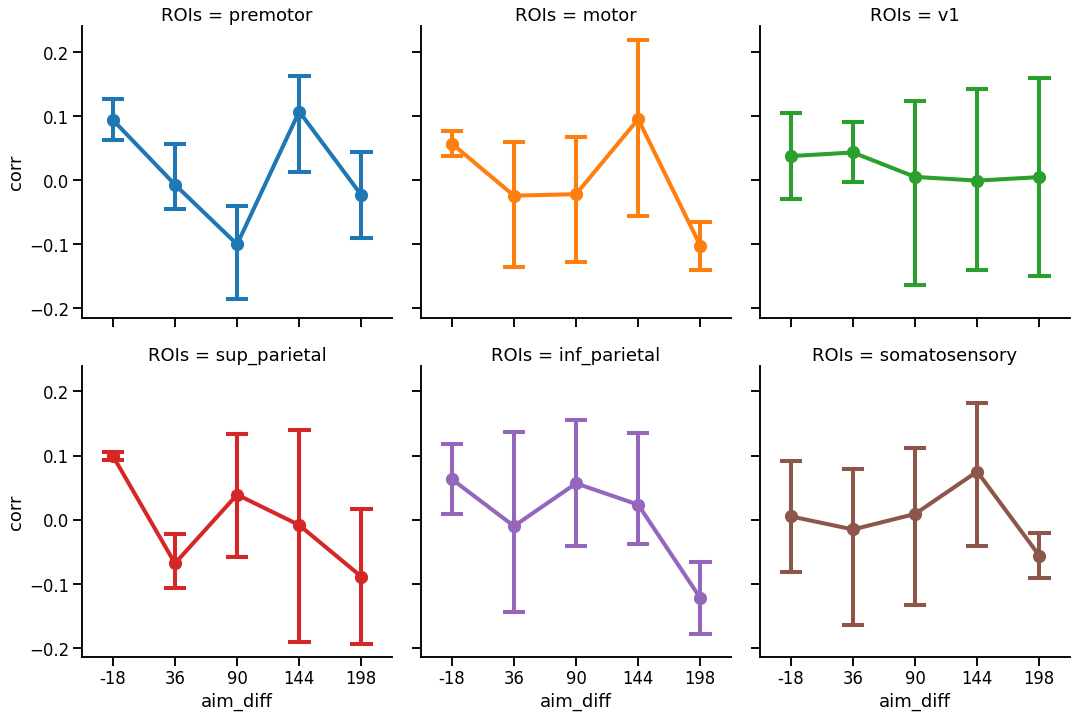

In [58]:
sns.catplot(x = "aim_diff", y = "corr", hue = 'ROIs', col = 'ROIs', col_wrap = 3,
            order = np.sort(np.unique(bw_correlations_melt['aim_diff'])),
            data = bw_correlations_melt.loc[((bw_correlations_melt['run_pairs'] == 1))], 
            kind = 'point', capsize = 0.3)
#plt.savefig('plots_for_bb/bw_corr_aim_diff_last_pair_non_mc.png', dpi = 600)

In [26]:
away = []
for i in bw_correlations_melt.correlations.str.split('_').values:
    away.append(np.abs((int(i[0]) - int(i[1]))/54))
    
bw_correlations_melt['targets_away'] = away

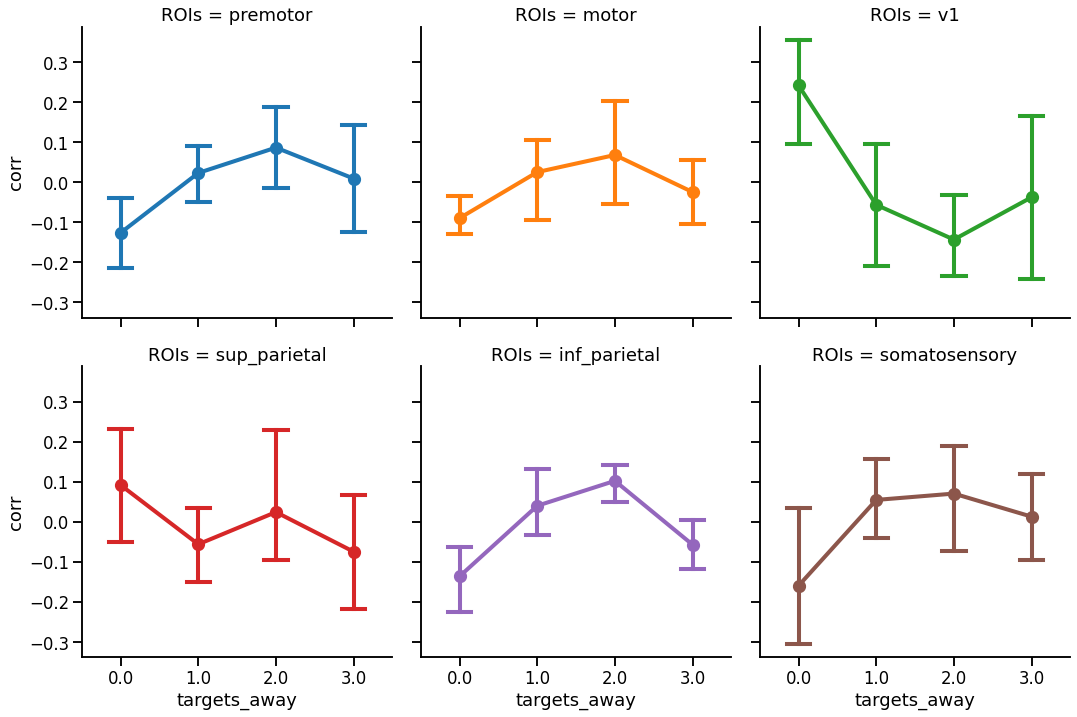

In [31]:
sns.catplot(x = "targets_away", y = "corr", hue = 'ROIs', col = 'ROIs', col_wrap = 3,
            order = np.sort(np.unique(bw_correlations_melt['targets_away'])),
            data = bw_correlations_melt.loc[((bw_correlations_melt['run_pairs'] == 5))], 
            kind = 'point', capsize = 0.3)
#plt.savefig('plots_for_bb/bw_corr_targ_away_last_pair.png', dpi = 600)

In [195]:

from IPython.display import Image
Image(filename='plots_for_bb/bw_corr_targ_away_last_pair.png')


In [110]:
a.mro()

NameError: name 'a' is not defined